In [25]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
import pydotplus
from IPython.display import Image

In [26]:
# 加载数据
train_data = pd.read_excel('银行借贷数据集train.xls')
test_data = pd.read_excel('银行借贷数据集test.xls')

# drop id
train_data = train_data.drop("nameid", axis=1)
test_data = test_data.drop("nameid", axis=1)

# revenue离散化
re = [0,10000,20000,30000,40000,50000]
train_data['revenue'] = pd.cut(train_data["revenue"], re, labels=False)
test_data["revenue"] = pd.cut(test_data["revenue"], re, labels=False)

# 合并训练集和测试集
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# 混洗数据集
combined_data = combined_data.sample(frac=1, random_state=1).reset_index(drop=True)

# 重新分割成新的训练集和测试集，假设80%为训练集，20%为测试集
train_size = int(0.8 * len(combined_data))
train_data = combined_data.iloc[:train_size]
test_data = combined_data.iloc[train_size:]

# 假设最后一列是目标变量
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

# 定义一个函数进行交叉验证
def cross_validate(X, y, model, cv=10):
    kf = KFold(n_splits=cv, shuffle=True, random_state=1)
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    for train_index, val_index in kf.split(X):
        X_kf_train, X_kf_val = X.iloc[train_index], X.iloc[val_index]
        y_kf_train, y_kf_val = y.iloc[train_index], y.iloc[val_index]
        
        clf = model
        clf.fit(X_kf_train, y_kf_train)
        y_kf_pred = clf.predict(X_kf_val)
        
        precision_scores.append(precision_score(y_kf_val, y_kf_pred))
        recall_scores.append(recall_score(y_kf_val, y_kf_pred))
        f1_scores.append(f1_score(y_kf_val, y_kf_pred))
    
    return np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores)

# 超参数搜索
best_params = None
best_f1_score = -1

# 这里假设我们只调节 max_depth 超参数
for max_depth in range(1, 11):
        model = DecisionTreeClassifier(max_depth=max_depth)
        precision, recall, f1 = cross_validate(X_train, y_train, model)
        print(f"Max Depth: {max_depth}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
    
        if f1 > best_f1_score:
            best_f1_score = f1
            best_params = {'max_depth': max_depth}

# 使用最优超参数重新训练模型
best_model = DecisionTreeClassifier(**best_params)
best_model.fit(X_train, y_train)

# 最佳超参数
print(best_params)

# 在测试集上评估模型
y_test_pred = best_model.predict(X_test)
precision, recall, f1 = precision_score(y_test, y_test_pred), recall_score(y_test, y_test_pred), f1_score(y_test, y_test_pred)

print(f"Test Set Evaluation - Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

Max Depth: 1, Precision: 0.6812499999999999, Recall: 1.0, F1 Score: 0.8094367346295412
Max Depth: 2, Precision: 0.7852082176399928, Recall: 0.8675113862771369, F1 Score: 0.8237369293171912
Max Depth: 3, Precision: 0.8064848988314939, Recall: 0.9706965332298794, F1 Score: 0.8803032275628212
Max Depth: 4, Precision: 0.8112864560749374, Recall: 0.9482824695741539, F1 Score: 0.8738703903357153
Max Depth: 5, Precision: 0.8061498175331503, Recall: 0.9453875118652857, F1 Score: 0.8691406580194434
Max Depth: 6, Precision: 0.8042165306872396, Recall: 0.910387627926099, F1 Score: 0.852939216488607
Max Depth: 7, Precision: 0.8054974451824686, Recall: 0.8771810683031258, F1 Score: 0.8383886753331711
Max Depth: 8, Precision: 0.8027207995250499, Recall: 0.8173059288043334, F1 Score: 0.8077474965920931
Max Depth: 9, Precision: 0.8087308300898748, Recall: 0.7939367599211022, F1 Score: 0.799859775604672
Max Depth: 10, Precision: 0.7984236869437688, Recall: 0.7721089006316898, F1 Score: 0.78273836824618

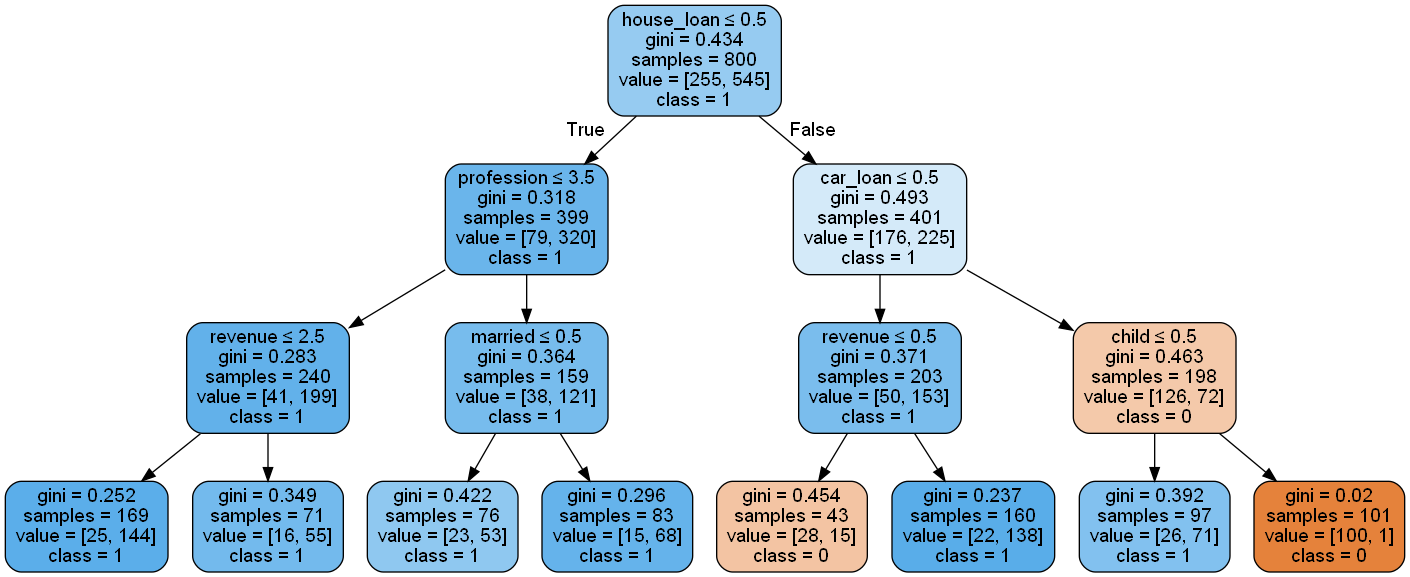

In [27]:
# 绘制决策树
dot_data = export_graphviz(best_model, out_file=None, 
                           feature_names=X_train.columns,  
                           class_names=['0', '1'],  
                           filled=True, rounded=True,  
                           special_characters=True)
dot_data = dot_data.replace("\n","")  
graph = pydotplus.graph_from_dot_data(dot_data)  

# 显示决策树
Image(graph.create_png())